# BERT

In [1]:
import os

import numpy as np
import tensorflow as tf
import wandb
from sklearn.metrics import (accuracy_score, classification_report,
                             f1_score, precision_score,
                             recall_score)
from sklearn.model_selection import train_test_split
from transformers import (DistilBertTokenizer,
                          TFDistilBertForSequenceClassification)
from wandb.keras import WandbCallback

from src.dataset import load_dataset
from src.evaluation import confusion_matrix_plot, acc_plot
from config import DATASETS, PROJECT_NAME

In [2]:
MODEL_NAME = "deepset/gbert-base"
TRACKING = True
FALSE_CLASS_BALANCE = 1.0

# dataset = DATASETS["dataset_1418"]
# dataset = DATASETS["SMC_2000"]
# dataset = DATASETS["SMC_1000"]
dataset = DATASETS["SMC_Full"]
# dataset = DATASETS["complete"]

### 0. Load data

In [3]:
train_text_split, X_test, train_labels_split, y_test = load_dataset(dataset_path=os.path.join(dataset["base_path"], dataset["data"]), false_class_balance=FALSE_CLASS_BALANCE)

In [4]:
y_train = train_labels_split.apply(lambda x: 0 if x==False else 1)
y_test = y_test.apply(lambda x: 0 if x==False else 1)

In [5]:
X_train, X_val, y_train, y_val = train_test_split(train_text_split, train_labels_split, test_size=.2, random_state=42) # train/test

In [6]:
print(X_train.size)
print(X_val.size)
print(y_train.size)

3834
960
1278


### 1. Prepare dataset

In [7]:
tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME) # load tokenizer

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'DistilBertTokenizer'.


In [8]:
def tokenize_dataset(dataset):
    """Tokenize a list of strings for the BERT model."""
    encoded = tokenizer(
        dataset,
        padding=True,
        truncation=True,
        return_tensors='np',
    )
    return encoded.data

In [9]:
encodet_train_text = tokenize_dataset(X_train["Sentence"].to_list())
encodet_val_texts = tokenize_dataset(X_val["Sentence"].to_list())
encodet_test_texts = tokenize_dataset(X_test["Sentence"].to_list())

### 2. Create Model

In [10]:
model = TFDistilBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)  # Load model

2022-01-19 16:32:14.305417: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-19 16:32:14.312696: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-19 16:32:14.313211: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-19 16:32:14.314083: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [12]:
# Set hyperparameter
# learning_rate = 1e-5
learning_rate = 0.01
epochs = 3
batch_size = 16

In [13]:
# from tensorflow.keras.optimizers.schedules import PolynomialDecay

# num_train_steps = (len(encodet_train_text['input_ids']) // batch_size) * epochs

# lr_scheduler = PolynomialDecay(
#     initial_learning_rate=5e-5,
#     end_learning_rate=0.,
#     decay_steps=num_train_steps
#     )

In [14]:
model = TFDistilBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
# optimizer = tf.keras.optimizers.Adam(learning_rate=lr_scheduler)

Some layers from the model checkpoint at deepset/gbert-base were not used when initializing TFDistilBertForSequenceClassification: ['mlm___cls', 'nsp___cls', 'bert']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-base and are newly initialized: ['distilbert', 'dropout_75', 'classifier', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
model.compile(
    optimizer=optimizer, 
    loss=loss,
    metrics=tf.metrics.SparseCategoricalAccuracy(),
    )

In [16]:
model.summary()

Model: "tf_distil_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 109335552 
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_75 (Dropout)        multiple                  0         
                                                                 
Total params: 109,927,682
Trainable params: 109,927,682
Non-trainable params: 0
_________________________________________________________________


### 3. Train model

In [17]:
if TRACKING:
  report = []
  model.summary(print_fn=lambda x: report.append(x))

  wandb.init(project=PROJECT_NAME,
          config={
              "model": MODEL_NAME,
              "setup": "\n".join(report),
              "dataset": dataset["name"],
              "train_data_size": len(X_train),
              "validation_data_size": len(X_val),
              "test_data_size": len(X_test),
              "batch_size": batch_size,
              "learning_rate": learning_rate,
              "epochs": epochs,
              "false_class_balance": FALSE_CLASS_BALANCE
          })

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jueri (use `wandb login --relogin` to force relogin)


In [18]:
history = model.fit(
      encodet_train_text,
      np.array(y_train), 
      validation_data=(encodet_val_texts, np.array(y_val)),
      epochs=epochs, 
      batch_size=batch_size,
      callbacks=[WandbCallback()]
      )

Epoch 1/3
80/80 [==============================] - ETA: 0s - loss: 1.5028 - sparse_categorical_accuracy: 0.5321

wandb: ERROR Can't save model, h5py returned error: Saving the model to HDF5 format requires the model to be a Functional model or a Sequential model. It does not work for subclassed models, because such models are defined via the body of a Python method, which isn't safely serializable. Consider saving to the Tensorflow SavedModel format (by setting save_format="tf") or using `save_weights`.


80/80 [==============================] - 23s 158ms/step - loss: 1.5028 - sparse_categorical_accuracy: 0.5321 - val_loss: 0.7010 - val_sparse_categorical_accuracy: 0.4938
Epoch 2/3
80/80 [==============================] - 12s 144ms/step - loss: 0.6951 - sparse_categorical_accuracy: 0.4922 - val_loss: 0.6934 - val_sparse_categorical_accuracy: 0.4938
Epoch 3/3
80/80 [==============================] - 11s 143ms/step - loss: 0.6936 - sparse_categorical_accuracy: 0.5172 - val_loss: 0.6931 - val_sparse_categorical_accuracy: 0.5063


### 4. Evaluate results

In [19]:
test_loss, test_accuracy = model.evaluate(encodet_test_texts, np.array(y_test))

13/13 [==============================] - 3s 111ms/step - loss: 0.6931 - sparse_categorical_accuracy: 0.5050


In [20]:
preds = model.predict(encodet_test_texts)

In [21]:
y_pred = np.argmax(preds.logits, axis=1)

In [22]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       198
           1       0.51      1.00      0.67       202

    accuracy                           0.51       400
   macro avg       0.25      0.50      0.34       400
weighted avg       0.26      0.51      0.34       400



/home/jueri/.local/share/virtualenvs/claim_model_comparison-fePjuQRa/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jueri/.local/share/virtualenvs/claim_model_comparison-fePjuQRa/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jueri/.local/share/virtualenvs/claim_model_comparison-fePjuQRa/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use 

In [23]:
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

In [24]:
if TRACKING:
    wandb.log({'test_f1': f1})
    wandb.log({'test_recall': recall})
    wandb.log({'test_precision': precision})
    wandb.log({'test_accuracy': accuracy})
    wandb.finish()

epoch,▁▅█
loss,█▁▁
sparse_categorical_accuracy,█▁▅
test_accuracy,▁
test_f1,▁
test_precision,▁
test_recall,▁
val_loss,█▁▁
val_sparse_categorical_accuracy,▁▁█
best_epoch,2
best_val_loss,0.69307


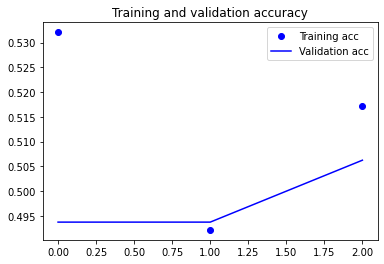

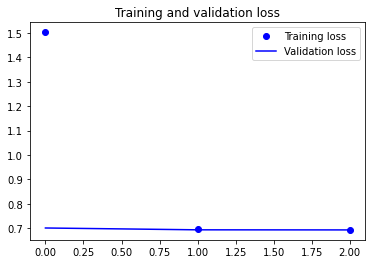

In [25]:
acc_plot(history)

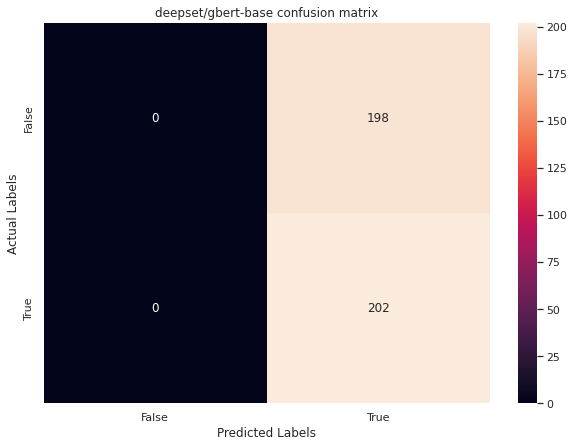

In [26]:
confusion_matrix_plot(y_test, y_pred, label=[False, True], title=MODEL_NAME+" confusion matrix")

In [27]:
# model.save_pretrained(os.path.join("data", "models", dataset["name"] + "_895"))